In [2]:
!pip install highlight_text


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import random

from os import listdir, mkdir, rename
from os.path import join, exists,isdir
import shutil
import datetime

import matplotlib.pyplot as plt
from highlight_text import ax_text, fig_text
from PIL import Image

import warnings

warnings.filterwarnings('ignore')


**Data:** https://www.kaggle.com/datasets/apollo2506/eurosat-dataset/data

# Image preparation

In [4]:
classes = [folder for folder in listdir('./EuroSat') if isdir(join('./EuroSat', folder))]
path_target = './EuroSat/all_targets'
path_input = './EuroSat/all_inputs'

# Noise

In [6]:
"""RUN IT ONLY ONCE TO RENAME THE FILES IN THE UNPACKED ARCHIVE"""
if not exists(path_input):
    mkdir(path_input)
if not exists(path_target):
    mkdir(path_target)

k = 1
for kind in classes:
    path = join('./EuroSat', str(kind))
    for i, f in enumerate(listdir(path)):
        shutil.copyfile(join(path, f), join(path_target, f))
        rename(join(path_target, f), join(path_target, f'{k}.jpg'))
        k += 1

In [7]:
def generate_perlin_noise(width, height, scale, octaves, persistence, lacunarity):
    noise = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise[i][j] = pnoise2(i / scale,
                                  j / scale,
                                  octaves=octaves,
                                  persistence=persistence,
                                  lacunarity=lacunarity,
                                  repeatx=width,
                                  repeaty=height,
                                  base=0)
    return noise

def normalize_noise(noise):
    min_val = noise.min()
    max_val = noise.max()
    return (noise - min_val) / (max_val - min_val)

def generate_clouds(width, height, base_scale, octaves, persistence, lacunarity):
    clouds = np.zeros((height, width))
    for octave in range(1, octaves + 1):
        scale = base_scale / octave
        layer = generate_perlin_noise(width, height, scale, 1, persistence, lacunarity)
        clouds += layer * (persistence ** octave)

    clouds = normalize_noise(clouds)
    return clouds

def overlay_clouds(image, clouds, alpha=0.5):

    clouds_rgb = np.stack([clouds] * 3, axis=-1)

    image = image.astype(float) / 255.0
    clouds_rgb = clouds_rgb.astype(float)

    blended = image * (1 - alpha) + clouds_rgb * alpha

    blended = (blended * 255).astype(np.uint8)
    return blended


In [8]:
!pip install noise


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import random
from noise import pnoise2

In [10]:
width, height = 64, 64
octaves = 12 #number of noise layers combined
persistence = 0.5 #lower persistence reduces the amplitude of higher-frequency octaves
lacunarity = 2 #higher lacunarity increases the frequency of higher-frequency octaves
for i in range(len(listdir(path_target))):
  base_scale = random.uniform(5,120) #noise frequency
  alpha = random.uniform(0,1) #transparency

  clouds = generate_clouds(width, height, base_scale, octaves, persistence, lacunarity)

  img = np.asarray(Image.open(join(path_target, f'{i+1}.jpg')))
  image = Image.fromarray(overlay_clouds(img,clouds, alpha))
  image.save(join(path_input,f'{i+1}.jpg'))
  print(f'Processed {i+1}/{len(listdir(path_target))}')

Processed 1/27000
Processed 2/27000
Processed 3/27000
Processed 4/27000
Processed 5/27000
Processed 6/27000
Processed 7/27000
Processed 8/27000
Processed 9/27000
Processed 10/27000
Processed 11/27000
Processed 12/27000
Processed 13/27000
Processed 14/27000
Processed 15/27000
Processed 16/27000
Processed 17/27000
Processed 18/27000
Processed 19/27000
Processed 20/27000
Processed 21/27000
Processed 22/27000
Processed 23/27000
Processed 24/27000
Processed 25/27000
Processed 26/27000
Processed 27/27000
Processed 28/27000
Processed 29/27000
Processed 30/27000
Processed 31/27000
Processed 32/27000
Processed 33/27000
Processed 34/27000
Processed 35/27000
Processed 36/27000
Processed 37/27000
Processed 38/27000
Processed 39/27000
Processed 40/27000
Processed 41/27000
Processed 42/27000
Processed 43/27000
Processed 44/27000
Processed 45/27000
Processed 46/27000
Processed 47/27000
Processed 48/27000
Processed 49/27000
Processed 50/27000
Processed 51/27000
Processed 52/27000
Processed 53/27000
Pr

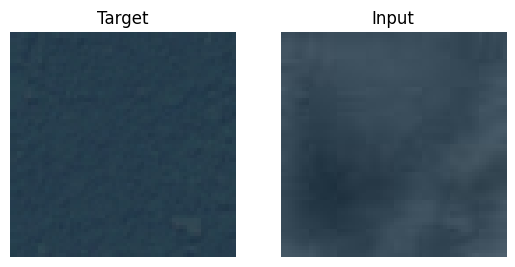

In [11]:
idx = np.random.randint(27000)
fig,ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(Image.open(join(path_target, f'{idx}.jpg'))))
ax[1].imshow(np.asarray(Image.open(join(path_input, f'{idx}.jpg'))))
ax[0].set_title("Target")
ax[0].axis('off')
ax[1].set_title("Input")
ax[1].axis('off')
plt.show()

# Creating Data Loader

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Subset

In [15]:
class dataset(Dataset):
  def __init__(self, batch_size, images_paths, targets, img_size = 64):
    self.batch_size = batch_size
    self.img_size = img_size
    self.images_paths = images_paths
    self.targets = targets
    self.len = len(self.images_paths) // batch_size

    self.transform = transforms.Compose([
                transforms.ToTensor(),
                ])


    self.batch_im = [self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size] for idx in range(self.len)]
    self.batch_t = [self.targets[idx * self.batch_size:(idx + 1) * self.batch_size] for idx in range(self.len)]

  def __getitem__(self, idx):
      pred = torch.stack([
              self.transform(Image.open(join(path_input,file_name)))
              for file_name in self.batch_im[idx]
          ])
      target = torch.stack([
              self.transform(Image.open(join(path_target,file_name)))
              for file_name in self.batch_im[idx]
          ])
      return pred, target

  def __len__(self):
      return self.len

In [18]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



In [21]:
train_dataset = dataset(batch_size=batch_size, images_paths=file_list, targets=file_list, transform=data_transforms)

In [16]:
class dataset(Dataset):
    def __init__(self, batch_size, images_paths, targets, img_size=64, transform=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.targets = targets
        self.len = len(self.images_paths) // batch_size
        self.transform = transform or transforms.ToTensor()  # Use passed transform or fallback

        self.batch_im = [self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size] for idx in range(self.len)]
        self.batch_t = [self.targets[idx * self.batch_size:(idx + 1) * self.batch_size] for idx in range(self.len)]

    def __getitem__(self, idx):
        pred = torch.stack([
            self.transform(Image.open(join(path_input, file_name)))
            for file_name in self.batch_im[idx]
        ])
        target = torch.stack([
            self.transform(Image.open(join(path_target, file_name)))
            for file_name in self.batch_im[idx]
        ])
        return pred, target

    def __len__(self):
        return self.len


In [ ]:
# batch_size = 32
# train_dataset = dataset(images_paths=file_list, targets=file_list)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# mean_img, mean_target, std_img, std_target = get_mean_std(train_loader)
# print(mean_img, mean_target, std_img, std_target)


tensor(0.0004) tensor(0.0003) tensor(9.1580e-05) tensor(5.1698e-05)


# Normalization check

In [19]:
def get_mean_std(loader):
    num_pixels = 0
    mean_img, std_img = 0.0, 0.0
    mean_target, std_target = 0.0, 0.0
    for images, targets in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean_img += images.mean(axis=(0, 2, 3)).sum()
        std_img += images.std(axis=(0, 2, 3)).sum()
        mean_target += targets.mean(axis=(0, 2, 3)).sum()
        std_target += targets.std(axis=(0, 2, 3)).sum()

    mean_img /= num_pixels
    mean_target /= num_pixels
    std_img /= num_pixels
    std_target /= num_pixels

    return mean_img, mean_target, std_img, std_target

# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# batch_size = 32
# mean_img, mean_target, std_img, std_target = get_mean_std(train_loader)
# mean_img, mean_target, std_img, std_target

In [20]:
file_list = sorted([f for f in listdir(path_input) if f.endswith('.jpg')])
batch_size = 32
train_dataset = dataset(batch_size=batch_size, images_paths=file_list, targets=file_list)

mean_img, mean_target, std_img, std_target = get_mean_std(train_dataset)
print(mean_img, mean_target, std_img, std_target)


tensor(1.0966e-05) tensor(8.6405e-06) tensor(3.8466e-06) tensor(2.9124e-06)


# Building Generator

In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_1 = DoubleConv(3, 32) # 64x64x64
      self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x32x32

      self.conv_2 = DoubleConv(32, 64)  #128x32x32
      self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2) #128x16x16

      self.conv_3 = DoubleConv(64, 128)  #256x16x16
      self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2) #256x8x8

      self.conv_4 = DoubleConv(128, 256)  #512x8x8
      self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2) #512x4x4

      self.conv_5 = DoubleConv(256, 512)  #1024x2x2

      #DECODER
      self.upconv_1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) #512x4x4
      self.conv_6 = DoubleConv(512, 256) #512x4x4


      self.upconv_2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) #256x8x8
      self.conv_7 = DoubleConv(256, 128)  #256x8x8

      self.upconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) #128x16x16
      self.conv_8 = DoubleConv(128, 64)  #128x16x16

      self.upconv_4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) #64x32x32
      self.conv_9 = DoubleConv(64, 32)  #64x32x32

      self.output = nn.Conv2d(32, 3, kernel_size = 3, stride = 1, padding = 1) #3x64x64

    def forward(self, batch):

      conv_1_out = self.conv_1(batch)
      conv_2_out = self.conv_2(self.pool_1(conv_1_out))
      conv_3_out = self.conv_3(self.pool_2(conv_2_out))
      conv_4_out = self.conv_4(self.pool_3(conv_3_out))
      conv_5_out = self.conv_5(self.pool_4(conv_4_out))

      conv_6_out = self.conv_6(torch.cat([self.upconv_1(conv_5_out), conv_4_out], dim=1))
      conv_7_out = self.conv_7(torch.cat([self.upconv_2(conv_6_out), conv_3_out], dim=1))
      conv_8_out = self.conv_8(torch.cat([self.upconv_3(conv_7_out), conv_2_out], dim=1))
      conv_9_out = self.conv_9(torch.cat([self.upconv_4(conv_8_out), conv_1_out], dim=1))

      output = self.output(conv_9_out)


      return F.sigmoid(output)

# Building Discriminator

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block=ResidualBlock, all_connections=[3,4,6,3]):
        super(ResNet, self).__init__()
        self.inputs = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU()) #64x64x64
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2) #64x32x32


        self.layer0 = self.makeLayer(block, 16, all_connections[0], stride = 1) #connections = 3, shape: 64x32x32
        self.layer1 = self.makeLayer(block, 32, all_connections[1], stride = 2)#connections = 4, shape: 128x16x16
        self.layer2 = self.makeLayer(block, 128, all_connections[2], stride = 2)#connections = 6, shape: 256x8x8
        self.layer3 = self.makeLayer(block, 256, all_connections[3], stride = 2)#connections = 3, shape: 512x4x4
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(256, 1)

    def makeLayer(self, block, outputs, connections, stride=1):
        downsample = None
        if stride != 1 or self.inputs != outputs:
            downsample = nn.Sequential(
                nn.Conv2d(self.inputs, outputs, kernel_size=1, stride=stride),
                nn.BatchNorm2d(outputs),
            )
        layers = []
        layers.append(block(self.inputs, outputs, stride, downsample))
        self.inputs = outputs
        for i in range(1, connections):
            layers.append(block(self.inputs, outputs))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x).flatten()
        return F.sigmoid(x)


# Training

In [24]:
test_ratio, train_ratio = 0.3, 0.7
num_test = int(len(listdir(path_target))*test_ratio)
num_train = int((int(len(listdir(path_target)))-num_test))

img_size = (64, 64)

print("Number of train samples:", num_train)
print("Number of test samples:", num_test)

random.seed(231)
train_idxs = np.array(random.sample(range(num_test+num_train), num_train))
mask = np.ones(num_train+num_test, dtype=bool)
mask[train_idxs] = False

images = {}
features = random.sample(listdir(path_input),num_test+num_train)
targets = random.sample(listdir(path_target),num_test+num_train)

random.Random(231).shuffle(features)
random.Random(231).shuffle(targets)

Number of train samples: 18900
Number of test samples: 8100


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
num_epochs = 10
learning_rate_D = 1e-5
learning_rate_G = 1e-4

In [26]:
train_input_img_paths = np.array(features)[train_idxs]
train_target_img_path = np.array(targets)[train_idxs]
test_input_img_paths = np.array(features)[mask]
test_target_img_path = np.array(targets)[mask]

train_loader = dataset(batch_size=batch_size, img_size=img_size, images_paths=train_input_img_paths, targets=train_target_img_path)
test_loader = dataset(batch_size=batch_size, img_size=img_size, images_paths=test_input_img_paths, targets=test_target_img_path)

In [27]:
discriminator = ResNet()
generator = UNet()

bce = nn.BCEWithLogitsLoss()
l1loss = nn.L1Loss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)

scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.1)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.1)

In [29]:
# Instantiate models
generator = UNet().to(device)
discriminator = ResNet().to(device)

# Load saved state_dict
generator.load_state_dict(torch.load("generator.pth", map_location=device))
discriminator.load_state_dict(torch.load("discriminator.pth", map_location=device))

# Set models to eval or train mode depending on what you're doing
generator.train()
discriminator.train()

print("✔️ Models loaded from generator.pth and discriminator.pth")


✔️ Models loaded from generator.pth and discriminator.pth


In [30]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)


In [32]:
num_epochs = 10  # total you want
start_epoch = 7  # since Python is 0-indexed, epoch 8 is index 7

train_loss_G, train_loss_D, val_loss_G, val_loss_D = [], [], [], []
all_loss_G, all_loss_D = [], []

best_generator_epoch_val_loss = -float("inf")
best_discriminator_epoch_val_loss = -float("inf")

for epoch in range(start_epoch, num_epochs):
    discriminator.train()
    generator.train()
    discriminator_epoch_loss, generator_epoch_loss = 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        fake = generator(inputs).detach()
        pred_fake = discriminator(fake)
        loss_fake = bce(pred_fake, torch.zeros_like(pred_fake))

        pred_real = discriminator(targets)
        loss_real = bce(pred_real, torch.ones_like(pred_real))

        loss_D = (loss_fake + loss_real) / 2
        loss_D.backward()
        optimizer_D.step()

        discriminator_epoch_loss += loss_D.item()
        all_loss_D.append(loss_D.item())

        # --- Train Generator ---
        optimizer_G.zero_grad()
        fake = generator(inputs)
        pred_fake = discriminator(fake)

        loss_G_bce = bce(pred_fake, torch.ones_like(pred_fake))
        loss_G_l1 = l1loss(fake, targets) * 100
        loss_G = loss_G_bce + loss_G_l1

        loss_G.backward()
        optimizer_G.step()

        generator_epoch_loss += loss_G.item()
        all_loss_G.append(loss_G.item())

    discriminator_epoch_loss /= len(train_loader)
    generator_epoch_loss /= len(train_loader)
    train_loss_D.append(discriminator_epoch_loss)
    train_loss_G.append(generator_epoch_loss)

    # Validation
    discriminator.eval()
    generator.eval()
    discriminator_epoch_val_loss, generator_epoch_val_loss = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            fake = generator(inputs)
            pred = discriminator(fake)

            loss_G_bce = bce(fake, torch.ones_like(fake))
            loss_G_l1 = l1loss(fake, targets) * 100
            loss_G = loss_G_bce + loss_G_l1
            loss_D = bce(pred, torch.zeros_like(pred))

            discriminator_epoch_val_loss += loss_D.item()
            generator_epoch_val_loss += loss_G.item()

    discriminator_epoch_val_loss /= len(test_loader)
    generator_epoch_val_loss /= len(test_loader)
    val_loss_D.append(discriminator_epoch_val_loss)
    val_loss_G.append(generator_epoch_val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss D: {discriminator_epoch_loss:.4f}, Val Loss D: {discriminator_epoch_val_loss:.4f}")
    print(f"Train Loss G: {generator_epoch_loss:.4f}, Val Loss G: {generator_epoch_val_loss:.4f}")

    # Save best models
    if discriminator_epoch_val_loss > best_discriminator_epoch_val_loss:
        best_discriminator_epoch_val_loss = discriminator_epoch_val_loss
        torch.save(discriminator.state_dict(), "discriminator.pth")
    if generator_epoch_val_loss > best_generator_epoch_val_loss:
        best_generator_epoch_val_loss = generator_epoch_val_loss
        torch.save(generator.state_dict(), "generator.pth")



Epoch [8/10]
Train Loss D: 0.6766, Val Loss D: 0.7453
Train Loss G: 4.3855, Val Loss G: 3.8772

Epoch [9/10]
Train Loss D: 0.6764, Val Loss D: 0.6985
Train Loss G: 4.2494, Val Loss G: 3.8815

Epoch [10/10]
Train Loss D: 0.6797, Val Loss D: 0.9860
Train Loss G: 4.1466, Val Loss G: 3.8042


------Epoch [1/15]------
Train Loss D: 0.6592, Val Loss D: 0.9223
Train Loss G: 7.8663, Val Loss G: 6.8207


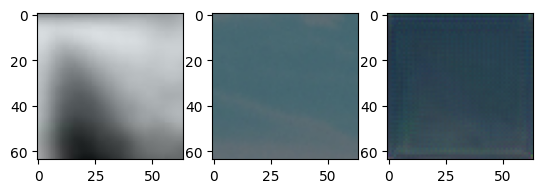

------Epoch [2/15]------
Train Loss D: 0.6547, Val Loss D: 0.7351
Train Loss G: 5.3886, Val Loss G: 6.0184


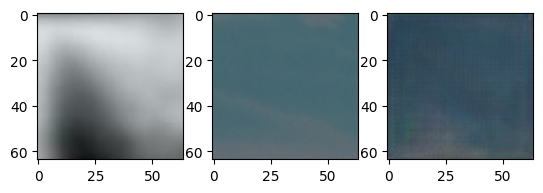

------Epoch [3/15]------
Train Loss D: 0.6726, Val Loss D: 0.7088
Train Loss G: 5.0175, Val Loss G: 5.3497


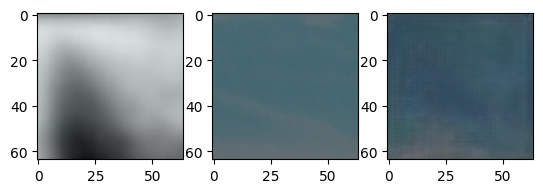

------Epoch [4/15]------
Train Loss D: 0.6772, Val Loss D: 0.8364
Train Loss G: 4.7623, Val Loss G: 5.2428


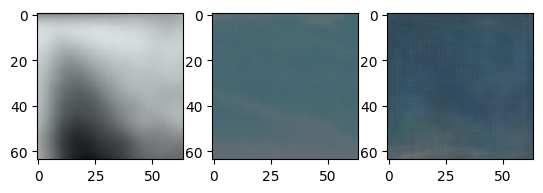

------Epoch [5/15]------
Train Loss D: 0.6693, Val Loss D: 0.7030
Train Loss G: 4.5868, Val Loss G: 5.0217


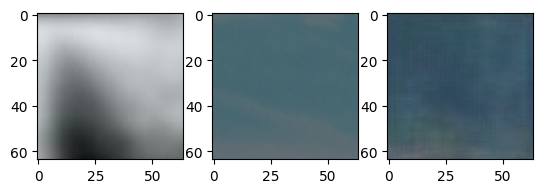

------Epoch [6/15]------
Train Loss D: 0.6794, Val Loss D: 0.7007
Train Loss G: 4.4531, Val Loss G: 4.9740


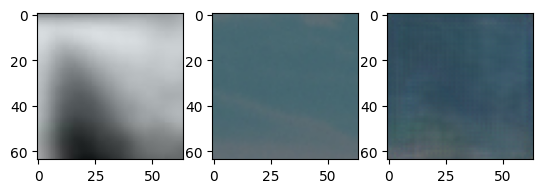

------Epoch [7/15]------
Train Loss D: 0.6867, Val Loss D: 0.8013
Train Loss G: 4.3138, Val Loss G: 4.8627


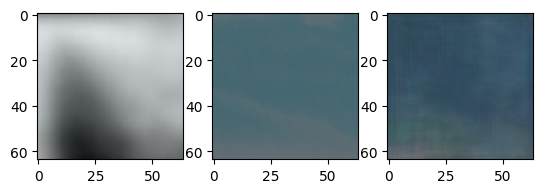

In [ ]:
train_loss_G, train_loss_D, val_loss_G, val_loss_D = [], [], [], []
all_loss_G, all_loss_D = [], []
best_generator_epoch_val_loss, best_discriminator_epoch_val_loss = -np.inf, -np.inf
for epoch in range(num_epochs):

    discriminator.train()
    generator.train()

    discriminator_epoch_loss, generator_epoch_loss = 0, 0

    for inputs, targets in train_loader:
        inputs, true = inputs, targets

        '''1. Training the Discriminator (ResNet)'''
        optimizer_D.zero_grad()

        fake = generator(inputs).detach()

        pred_fake = discriminator(fake).to(device)
        loss_fake = bce(pred_fake, torch.zeros(batch_size, device=device))

        pred_real = discriminator(true).to(device)
        loss_real = bce(pred_real, torch.ones(batch_size, device=device))

        loss_D = (loss_fake+loss_real)/2

        loss_D.backward()
        optimizer_D.step()

        discriminator_epoch_loss += loss_D.item()
        all_loss_D.append(loss_D.item())

        '''2. Training the Generator (UNet)'''
        optimizer_G.zero_grad()

        fake = generator(inputs)
        pred_fake = discriminator(fake).to(device)
        
        loss_G_bce = bce(pred_fake, torch.ones_like(pred_fake, device=device))
        loss_G_l1 = l1loss(fake, targets)*100
        loss_G = loss_G_bce + loss_G_l1
        loss_G.backward()
        optimizer_G.step()

        generator_epoch_loss += loss_G.item()
        all_loss_G.append(loss_G.item())

    discriminator_epoch_loss /= len(train_loader)
    generator_epoch_loss /= len(train_loader)
    train_loss_D.append(discriminator_epoch_loss)
    train_loss_G.append(generator_epoch_loss)

    discriminator.eval()
    generator.eval()

    discriminator_epoch_val_loss, generator_epoch_val_loss = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs, targets

            fake = generator(inputs)
            pred = discriminator(fake).to(device)
            
            loss_G_bce = bce(fake, torch.ones_like(fake, device=device))
            loss_G_l1 = l1loss(fake, targets)*100
            loss_G = loss_G_bce + loss_G_l1
            loss_D = bce(pred.to(device), torch.zeros(batch_size, device=device))

            discriminator_epoch_val_loss += loss_D.item()
            generator_epoch_val_loss += loss_G.item()

    discriminator_epoch_val_loss /= len(test_loader)
    generator_epoch_val_loss /= len(test_loader)

    val_loss_D.append(discriminator_epoch_val_loss)
    val_loss_G.append(generator_epoch_val_loss)

    print(f"------Epoch [{epoch+1}/{num_epochs}]------\nTrain Loss D: {discriminator_epoch_loss:.4f}, Val Loss D: {discriminator_epoch_val_loss:.4f}")
    print(f'Train Loss G: {generator_epoch_loss:.4f}, Val Loss G: {generator_epoch_val_loss:.4f}')

    if discriminator_epoch_val_loss > best_discriminator_epoch_val_loss:
        discriminator_epoch_val_loss = best_discriminator_epoch_val_loss
        torch.save(discriminator.state_dict(), "discriminator.pth")
    if generator_epoch_val_loss > best_generator_epoch_val_loss:
        generator_epoch_val_loss = best_generator_epoch_val_loss
        torch.save(generator.state_dict(), "generator.pth")
    #scheduler_D.step()
    #scheduler_G.step()

    fig, ax = plt.subplots(1,3)
    ax[0].imshow(np.transpose(inputs.numpy()[7], (1,2,0)))
    ax[1].imshow(np.transpose(targets.numpy()[7], (1,2,0)))
    ax[2].imshow(np.transpose(fake.detach().numpy()[7], (1,2,0)))
    plt.show()

In [33]:
np.array(all_loss_D).max()

0.7912958860397339

In [35]:
from matplotlib.font_manager import FontProperties

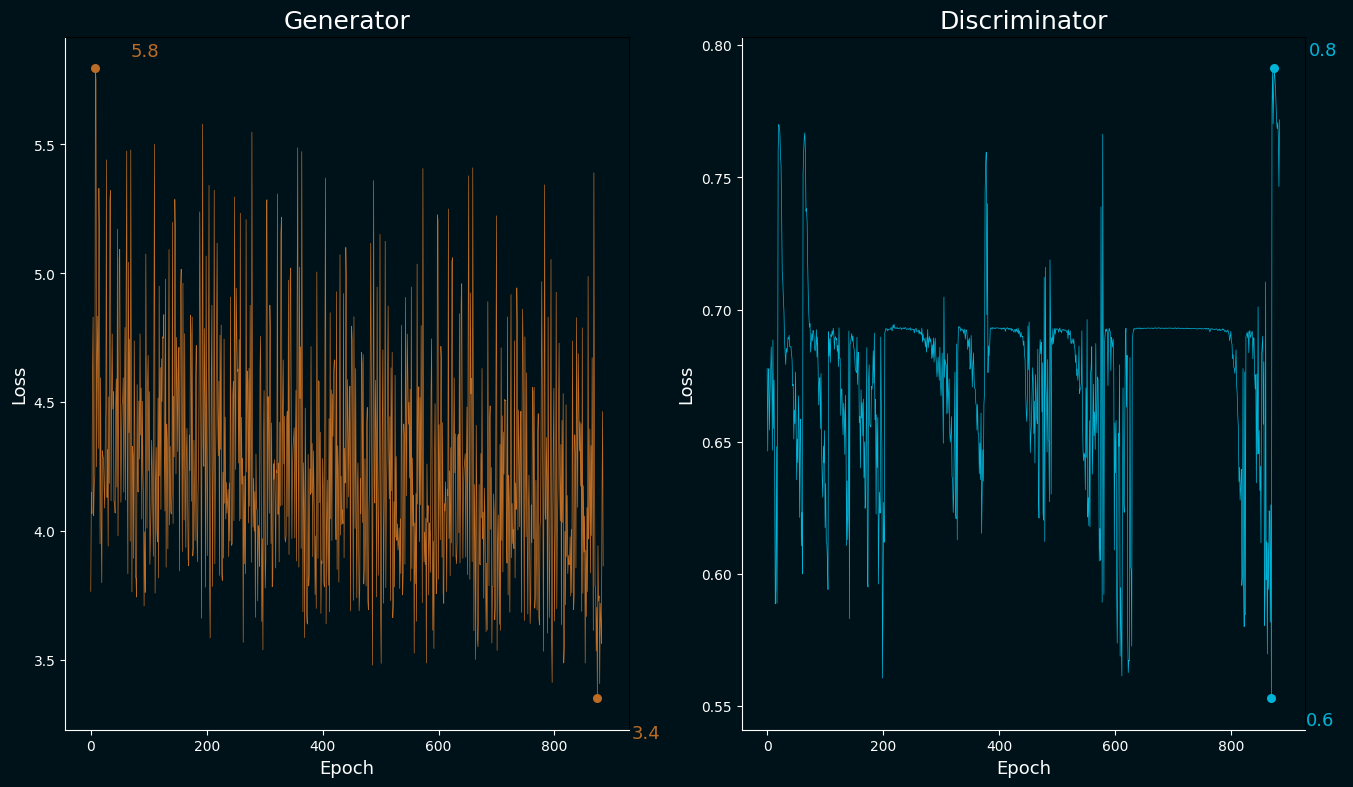

In [37]:
from matplotlib.font_manager import FontProperties

background_color = '#001219'
font = FontProperties(family='DejaVu Sans') 
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
fig.set_facecolor(background_color)
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)

ax[0].plot(range(len(all_loss_G)), all_loss_G, color='#bc6c25', lw=0.5) 
ax[1].plot(range(len(all_loss_D)), all_loss_D, color='#00b4d8', lw=0.5)

ax[0].scatter(
      [np.array(all_loss_G).argmax(), np.array(all_loss_G).argmin()],
      [np.array(all_loss_G).max(), np.array(all_loss_G).min()],
      s=30, color='#bc6c25',
   )
ax[1].scatter(
      [np.array(all_loss_D).argmax(), np.array(all_loss_D).argmin()],
      [np.array(all_loss_D).max(), np.array(all_loss_D).min()],
      s=30, color='#00b4d8',
   )

ax_text(
      np.array(all_loss_G).argmax()+60, np.array(all_loss_G).max()+0.1,
      f'{round(np.array(all_loss_G).max(),1)}',
      fontsize=13, color='#bc6c25',
      font=font,
      ax=ax[0]
   )
ax_text(
      np.array(all_loss_G).argmin()+60, np.array(all_loss_G).min()-0.1,
      f'{round(np.array(all_loss_G).min(),1)}',
      fontsize=13, color='#bc6c25',
      font=font,
      ax=ax[0]
   )

ax_text(
      np.array(all_loss_D).argmax()+60, np.array(all_loss_D).max()+0.01,
      f'{round(np.array(all_loss_D).max(),1)}',
      fontsize=13, color='#00b4d8',
      font=font,
      ax=ax[1]
   )
ax_text(
      np.array(all_loss_D).argmin()+60, np.array(all_loss_D).min()-0.005,
      f'{round(np.array(all_loss_D).min(),1)}',
      fontsize=13, color='#00b4d8',
      font=font,
      ax=ax[1]
   )
for i in range(2):
    ax[i].tick_params(axis='x', colors='white')
    ax[i].tick_params(axis='y', colors='white')
    ax[i].spines['left'].set_color('white') 
    ax[i].spines['bottom'].set_color('white') 
    ax[i].set_xlabel('Epoch', color='white', fontproperties=font, fontsize=13)
    ax[i].set_ylabel('Loss', color='white', fontproperties=font, fontsize=13)

ax[0].set_title('Generator', color='white', fontproperties=font, fontsize=18)
ax[1].set_title('Discriminator', color='white', fontproperties=font, fontsize=18)
plt.savefig('Loss.jpg')
plt.show()
# ax[0].set_axis_off()
# ax[1].set_axis_off()


In [39]:
random.Random(2).shuffle(test_target_img_path)
random.Random(2).shuffle(test_input_img_paths)
subset_loader = dataset(batch_size=5, img_size=img_size, images_paths=test_input_img_paths,
                        targets=test_target_img_path)
generator = UNet()
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

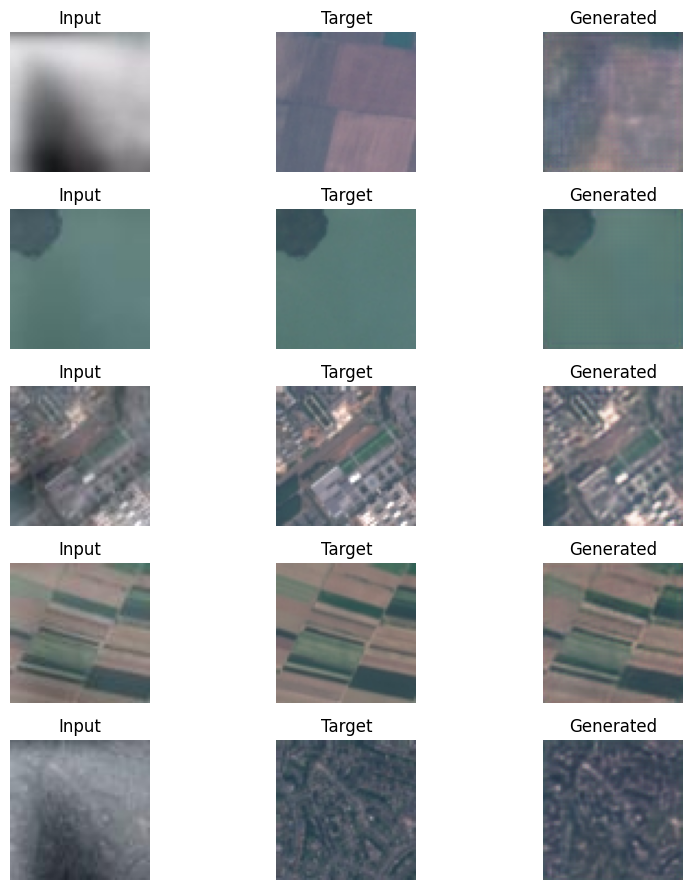

In [43]:
generator.eval()
for X, y in subset_loader:
    fig, axes = plt.subplots(5, 3, figsize=(9, 9))

    for i in range(5):
        axes[i, 0].imshow(np.transpose(X.numpy()[i], (1, 2, 0)))
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(np.transpose(y.numpy()[i], (1, 2, 0)))
        axes[i, 1].set_title("Target")
        axes[i, 1].axis('off')
        
        generated_image = generator(X[i].unsqueeze(0)).detach().numpy()[0]
        axes[i, 2].imshow(np.transpose(generated_image, (1, 2, 0)))
        axes[i, 2].set_title("Generated")
        axes[i, 2].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('Test.jpg')
    plt.show()
    break 

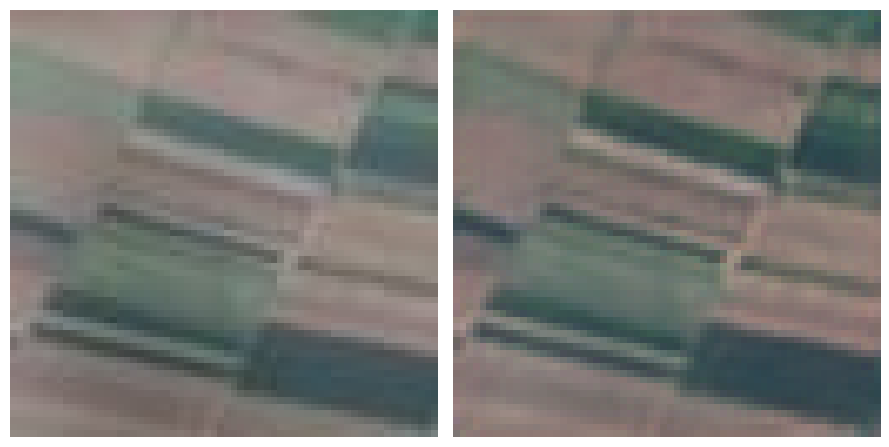

In [42]:
for X, y in subset_loader:
    fig, axes = plt.subplots(1, 2, figsize=(9, 6))

    axes[0].imshow(np.transpose(X.numpy()[3], (1, 2, 0)))
    #axes[0].set_title("Input")
    axes[0].axis('off')
        
    generated_image = generator(X[3].unsqueeze(0)).detach().numpy()[0]
    axes[1].imshow(np.transpose(generated_image, (1, 2, 0)))
    #axes[1].set_title("Generated")
    axes[1].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('Main.jpg')
    plt.show()
    break